In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Import Data

In [2]:
df = pd.read_csv("simple_exercise/BeerWineLiquor.csv")
df['date'] = pd.to_datetime(df['date']).dt.date
df.head(5)

,date,beer
0,1992-01-01,1509
1,1992-02-01,1541
2,1992-03-01,1597
3,1992-04-01,1675
4,1992-05-01,1822


In [177]:
df.dtypes

date    object
beer     int64
dtype: object

<Axes: xlabel='date', ylabel='beer'>

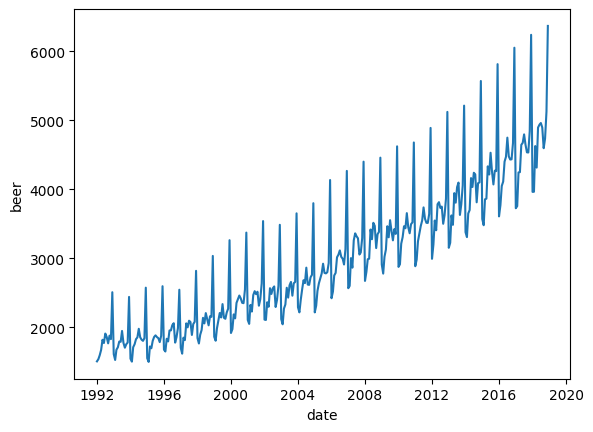

In [3]:
## ряд не стационарен – имеется тренд, имеется сезонность, растет дисперсия
sns.lineplot(df, x='date', y='beer')

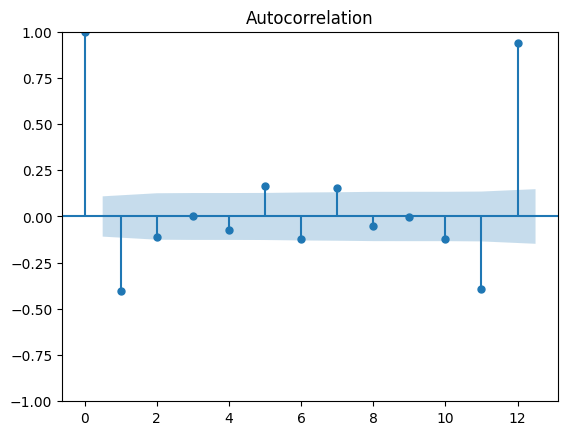

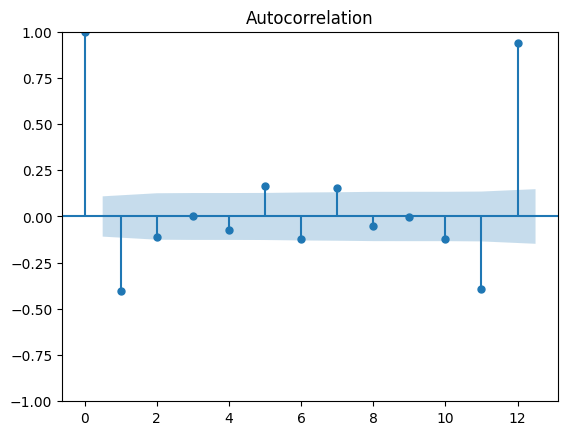

In [4]:
###сильная годовая сезонность
plot_acf(df.beer.diff(1).dropna(), lags=12)

### Data Transformation

In [133]:
## выравниваем дисперсию 
df['beer_fix'] = np.log(df.beer)

##убираем сезонность
df['beer_fix'] = df.beer_fix.diff(12).dropna()

##убираем тренд
df['beer_fix'] = df.beer_fix.diff().dropna()

<Axes: xlabel='date', ylabel='beer_fix'>

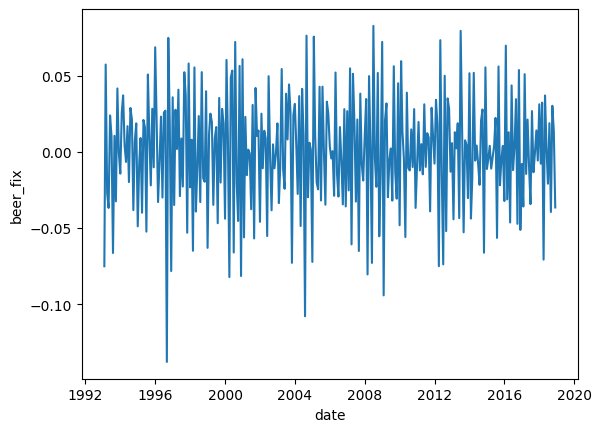

In [134]:
sns.lineplot(df, x='date', y='beer_fix')

In [135]:
# ADF тест
adf_result = adfuller(df['beer_fix'].dropna())
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print('reject H0')
    print('ряд стационарен')

p-value: 7.220678194343494e-14
reject H0
ряд стационарен


### Простейшие модели (baseline)

In [136]:
y = df['beer']

n_test = 12

train, test = y[:-n_test], y[-n_test:]

### white noise (mean)

mean_forecast = np.repeat(train.mean(), n_test)

#### naive (random walk)

naive_forecast = np.repeat(train.iloc[-1], n_test)

### naive seasonal

m = 12 ###seasonality
seasonal_forecast = y.iloc[-(n_test+m):-m]


print('MAPE White Noise:', mean_absolute_percentage_error(test, mean_forecast))
print('MAPE Naive:', mean_absolute_percentage_error(test, naive_forecast))
print('MAPE Naive Seasonal:', mean_absolute_percentage_error(test, seasonal_forecast))

MAPE White Noise: 0.384321875242107
MAPE Naive: 0.32688251688259967
MAPE Naive Seasonal: 0.04415856742989575


In [137]:
### оцениваем остатки для сезонной модели

resid_seasonal = train.iloc[m:] - train.iloc[:-m].values
sigma2_seas = np.var(resid_seasonal, ddof=1)

se = np.sqrt(sigma2_seas)

point1 = -2
point2 = -1

print('forecast:', seasonal_naive_forecast[point1:point2].values[0])
print('CI lower:', seasonal_naive_forecast[point1:point2].values[0] - 1.96 * se)
print('CI upper:', seasonal_naive_forecast[point1:point2].values[0] + 1.96 * se)

forecast: 4846
CI lower: 4652.705071823414
CI upper: 5039.294928176586


### AutoRegression Model (AR)

In [138]:
df_auto = df.set_index(df.date).drop(columns='date').dropna()
df_auto.head()

,beer,beer_fix
date,,
1993-02-01,1529,-0.075086
1993-03-01,1678,0.057293
1993-04-01,1713,-0.027043
1993-05-01,1796,-0.036806
1993-06-01,1792,0.023905


In [140]:
n_test = 12 ## 1 год для теста

train, test = df_auto[:-n_test].beer, df_auto[-n_test:].beer

In [141]:
lag = 12 ##пробуем прогноз на предыдущее значение года

model = AutoReg(train, lags=lag).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                   beer   No. Observations:                  299
Model:                    AutoReg(12)   Log Likelihood               -1692.947
Method:               Conditional MLE   S.D. of innovations             88.220
Date:                Thu, 04 Sep 2025   AIC                           3413.894
Time:                        19:33:50   BIC                           3465.127
Sample:                    02-01-1994   HQIC                          3434.427
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.3030     19.582     -0.475      0.635     -47.683      29.077
beer.L1        0.0014      0.013      0.111      0.912      -0.024       0.027
beer.L2        0.0127      0.013      0.981      0.3

/Users/r10/jupyter_project/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [142]:
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
mape = mean_absolute_percentage_error(test, pred) * 100
print("MAPE:", round(mape,2), '%')

MAPE: 1.52 %


/Users/r10/jupyter_project/venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


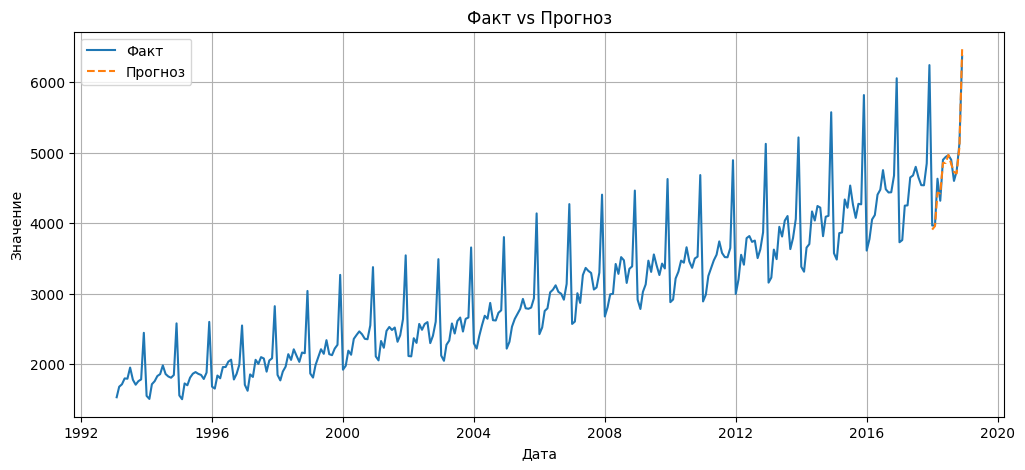

In [143]:
plt.figure(figsize=(12,5))
plt.plot(df_auto.index, df_auto.beer.values, label='Факт')
plt.plot(pred.index, pred.values, linestyle='--', label='Прогноз')

plt.title('Факт vs Прогноз')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

1993-01-01             1614.000000
1993-02-01             1529.000000
1993-03-01             1678.000000
1993-04-01             1713.000000
1993-05-01             1796.000000
                          ...     
2018-08-01 00:00:00    4839.456879
2018-09-01 00:00:00    4724.321410
2018-10-01 00:00:00    4705.598599
2018-11-01 00:00:00    5081.326497
2018-12-01 00:00:00    6466.873235
Length: 312, dtype: float64

In [83]:
pred

2018-01-01    3904.723587
2018-02-01    3959.179321
2018-03-01    4430.498825
2018-04-01    4422.588126
2018-05-01    4853.881125
2018-06-01    4854.791708
2018-07-01    4968.101970
2018-08-01    4839.456879
2018-09-01    4724.321410
2018-10-01    4705.598599
2018-11-01    5081.326497
2018-12-01    6466.873235
Freq: MS, dtype: float64